In [97]:
#we import the libraries 
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.image as mpimg

# Traineeship : Numerical Fluid Dynamics
## 2D Stokes flow around a square (bis)
### Paradox solving

##### Ilan Renous

#### In the paper "2D Stokes flow around a square", some questions remained unanswered. In this paper, we will try to find an appropriate way to answer those questions.

First, we need to define all the functions used in the original "2D Stokes flow around a square" paper. For information about those functions, refer to the original paper.

In [98]:
def stokes_system(r,xi,yi,h,nx,ny,w,psi,l1_target,dx,dy,u,boundary):
    '''Performs Jacobi relaxation for the cavity flow
    
    Parameters:
    ----------
    r: float
        lentgth of the central square
    xi,yi: float
        position of the center of the central square
    dx: float
        Mesh spacing in x direction
    h: float
        heigth of the cavity
     nx, ny: 2D array of floats
        grid
    w : 2D array of floats
        Initial guess
    psi: 2D array of floats
        Initial guess
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l1_target: float
        Target difference between two consecutive iterates
    u: float
        speed of the undisturbed flow
    y: float
        Mesh spacing in y direction
    boundary: integer
        determine the BCS function tu use
    Returns:
    -------
    w: 2D array of float
        Distribution after relaxation      
    psi: 2D array of float
        Distribution after relaxation
    iteration: number of iteration

    ''' 
    iteration=0
    stop1=1 # we fix the norm to be one to run the loop at least once
    stop2=1
    psin = numpy.empty_like(psi)
    wn= numpy.empty_like(w)
    wk= numpy.empty_like(w)
    wk=w.copy()
    
    while(stop1>l1_target or stop2>l1_target):
        
        psin=psi.copy()
        wn=wk.copy()
        wk[1:-1,1:-1]=.25*(wn[2:,1:-1]+wn[:-2,1:-1]+wn[1:-1,:-2]+wn[1:-1,2:])
        
        psi[1:-1:,1:-1]=.25*((dx**2)*wn[1:-1,1:-1]+psin[2:,1:-1] \
                             +psin[:-2,1:-1]+psi[1:-1,:-2]+psin[1:-1,2:]) 
        
        #BCs function to use
        if boundary==1:
            psi,wk = BCs_obstacle1(wk,psi,y,xi,yi,r,h,u)
        if boundary==2:    
            psi,wk = BCs_obstacle2(wk,psi,y,xi,yi,r,h,u)
        if boundary==3:   
            psi,wk = BCs_obstacle3(wk,psi,y,xi,yi,r,h,u)
        
        stop1=L1norm(psi,psin)
        stop2=L1norm(wk,wn)
        iteration+=1
        
        if iteration>50000: #safety break
            break
        
    return wk,psi, iteration

In [99]:
def BCs_obstacle3(w,psi,y,xi,yi,r,h,u):
    '''BCs for a square obstacle in the middle of the grid and uniform speed u at the edge of the cavity
    
    Parameters:
    ----------
    w : 2D array of floats
        w on the Boundaries
    psi: 2D array of floats
        psi on the Boundaries
    xi: float
        middle of the x axis
    yi: float
        middle of the y axis
    r: float
        1/2 side of the cube
    h: float
        height of the cavity
    u: float
        speed of the flow on the on the edge of the cavity
    
    Returns:
    -------
    psi: 2D array of float
        Distribution after BCs
    w: 2D array of float
        Distribution after BCs
    ''' 

    #BCs cavity
        
    w[-1,:]= (-1/dx**2)*(6*dy*u-7*psi[-1,:]+8*psi[-2,:]-psi[-3,:])
    w[0,:]= (-1/dx**2)*(-6*dy*u-7*psi[0,:]+8*psi[1,:]-psi[2,:])
    w[:,0]= (-1/dx**2)*(-7*psi[:,0]+8*psi[:,1]-psi[:,2])
    w[:,-1]= (-1/dx**2)*(-7*psi[:,-1]+8*psi[:,-2]-psi[:,-3])
    
    #BCs square
    w[yi-r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi-r-1,xi-r:xi+r+1]-7*u*(h/2)-psi[yi-r-2,xi-r:xi+r+1])
    w[yi-r:yi+r+1,xi-r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi-r-1]-7*u*(h/2)-psi[yi-r:yi+r+1,xi-r-2])
    w[yi+r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi+r+1,xi-r:xi+r+1]-7*u*(h/2)-psi[yi+r+2,xi-r:xi+r+1])
    w[yi-r:yi+r+1,xi+r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi+r+1]-7*u*(h/2)-psi[yi-r:yi+r+1,xi+r+2])
        
    return psi,w

In [100]:
def L1norm(new, old):
    '''compute the norm between psi(k+1) and psi(k)
    
    Parameters:
    ----------
    new : 2D array of floats
        psi(k+1)
    old: 2D array of floats
        psi(k)
        
    Returns:
    -------
    norm: float
        norm between psi(k) and psi(k+1)
    ''' 
    norm = numpy.sum(numpy.abs(new-old))
    return norm


In [101]:
# resolution 
nx=51
ny=51
    
# cavity of length l and height h
l=1
h=1

# speed of the flow u
u=1

#dimension of the central square
r=int((nx-1)/10)
#position of the center of the square
xi=int((nx-1)/2)
yi=int((ny-1)/2)

#grid
x=numpy.linspace(0,l,nx)
y=numpy.linspace(0,h,ny)
#grid mesh
dx=l/(nx-1)
dy=h/(ny-1)

#norm target
l1_target = 1e-6

#potential flow
w=numpy.zeros((nx,ny))
psi=numpy.zeros((nx,ny))

#values of psi=u*y on the cavity's boundaries
psi[:,0]=u*y[:]
psi[:,-1]=u*y[:]
psi[-1,:]=u*y[-1]
psi[0,:]=u*y[0]

In [102]:
#we choose the third BCs function
boundary=3

#compute psi
w3,psi3,iteration = stokes_system(r,xi,yi,h,nx,ny,w,psi,l1_target,dx,dy,u,3)
print("number of iterations =",iteration)

number of iterations = 3120


In [103]:
def speed(psi,nx,ny,dx,dy):
    '''compute the speed from the stream function
    
    Parameters:
    ----------
    psi : 2D array of floats
        stream function
    nx: float
        array size x axis
    ny:float
        array size y axis
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    
    Returns:
    -------
    ux: 2D array of float
        speed in the x direction
    vy:2D array of float
        speed in the y direction
    ''' 
    ux=numpy.zeros((nx,ny))
    vy=numpy.zeros((nx,ny))
    
    ux[:,0]=u
    ux[:,-1]=u
    ux[0,:]=u
    ux[-1,:]=u
    ux[1:-1,1:-1]=(1/(2*dy))*(psi[2:,1:-1]-psi[0:-2,1:-1])
    
    vy[:,0]=0
    vy[:,-1]=0
    vy[0,:]=0
    vy[-1,:]=0
    vy[1:-1,1:-1]=-(1/(2*dx))*(psi[1:-1,2:]-psi[1:-1,0:-2])
    
    return ux,vy

In [104]:
#define the square
j=numpy.linspace(x[xi-r],x[xi+r],100)
p=numpy.linspace(y[yi-r],y[yi+r],100)
k=numpy.zeros(100)
l=numpy.zeros(100)
m=numpy.zeros(100)
n=numpy.zeros(100)
k[:]=x[xi+r]
l[:]=x[xi-r]
m[:]=y[yi+r]
n[:]=y[yi-r]

### The computed flow stream is illustrated bellow

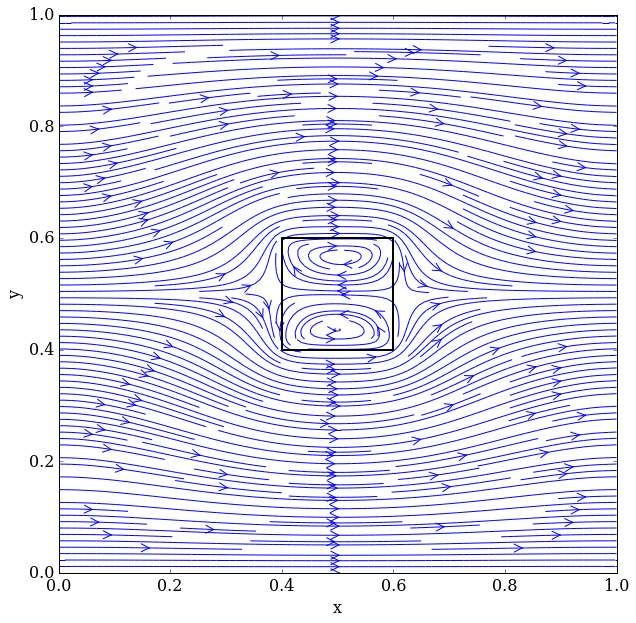

In [105]:
#compute the speed
ux3, vy3=speed(psi3,nx,ny,dx,dy)
#usual plot

#define a meshgrid to plot the stream
X, Y =numpy.meshgrid(x,y)
size=10
pyplot.figure(figsize=(size, (y[-1]-y[0])/(x[-1]-x[0])*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x[0],x[-1])
pyplot.ylim(y[0], y[-1])
#plot the central square
pyplot.plot(j,m, color='k', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='k', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='k', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='k', linestyle='-', linewidth=2)
#plot of the flow speed
pyplot.streamplot(X, Y, ux3, vy3, density=3, linewidth=1, arrowsize=2, arrowstyle='->')

## Pressure and Force

The equation linking the pressure $p$ and the velocity $\vec{u}$ is

\begin{equation}
\vec{\nabla} p = \Delta\vec{u}
\end{equation}

Taking the gradient of each side of this equation yields


\begin{equation}
\Delta p = \Delta\vec{\nabla}\vec{u}
\end{equation}

Since the fluid is incompressible, we simply have 

\begin{equation}
\Delta p =0
\end{equation}

This is a Laplace equation with the Von Neumann boundary conditions on the cavity's edges and on the cube


\begin{equation}
\frac{\partial p}{\partial x}=\Delta u
\end{equation}

and 

\begin{equation}
\frac{\partial p}{\partial y}=\Delta v
\end{equation}

First, we need $\Delta\vec{u}$ everywhere in the cavity for the different flow speed found above.

In [106]:
def lap(ux,uy,nx,ny,dx,dy):
    '''compute the laplacian of the speed
    Parameters:
    ----------
    ux : 2D array of floats
        speed in the x-direction
    uy : 2D array of floats
        speed in the y-direction    
    nx: float
        array size x axis
    ny:float
        array size y axis
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    Returns:
    -------
    lapx: 2D array of float
        x component of the vectorial laplacian
    lapy:2D array of float
        y component of the vectorial laplacian
    '''

    lapx=numpy.zeros((nx,ny))
    lapy=numpy.zeros((nx,ny))
    
    lapx[1:-1,1:-1]=1/(dx**2)*(ux[1:-1,2:]-2*ux[1:-1,1:-1]+ux[1:-1,:-2])\
    +(1/(dy**2))*(ux[2:,1:-1]-2*ux[1:-1,1:-1]+ux[:-2,1:-1])
    
    lapy[1:-1,1:-1]=(1/(dx**2))*(uy[1:-1,2:]-2*uy[1:-1,1:-1]+uy[1:-1,:-2])\
    +(1/(dy**2))*(uy[2:,1:-1]-2*uy[1:-1,1:-1]+uy[:-2,1:-1])
    
    return lapx,lapy
lapx3,lapy3=lap(ux3,vy3,nx,ny,dx,dy)

### On the original paper, we used the following first order discrete conditions:

For the top edge of the cavity, the discrete form of these equations is

\begin{equation}
p_{i,j}=p_{i+1,j}-\Delta u_{i,j} dx
\end{equation}

\begin{equation}
p_{i,j}=p_{i,j-1}+\Delta v_{i,j} dx
\end{equation}

Adding them  one to another gives the expression for the pressure on the top edge of the cavity

\begin{equation}
p_{i,j}=\frac{p_{i,j-1}+p_{i+1,j}+(\Delta v_{i,j}-\Delta u_{i,j})dx}{2}
\end{equation}

From a similar argument, we find the conditions on the other edges of the cavity and on the central square.

In [107]:
def laplace2d1(lapx,lapy, l1_target,nx,ny,dx,dy):
    '''Iteratively solves the Laplace equation using the Jacobi method
    
    Parameters:
    ----------
    P: 2D array of float
        Initial Pressure distribution
    lapx: 2D array of float
        x component of the speed laplacian
    lapy:2D array of float
        y component of the speed laplacian
    l1_target: float
        target for the difference between consecutive solutions
    nx: float
        array size x axis
    ny:float
        array size y axis
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
        
    Returns:
    -------
    P: 2D array of float
        Pressure distribution after relaxation
    '''
    
    l2norm = 1
    P=numpy.zeros((nx,ny))

    Pn = numpy.empty_like(p)
    iterations = 0
    lnorm=1
    
    while lnorm > l1_target:
        Pn = P.copy()
        
        P[2:-2,2:-2] = .25 * (Pn[2:-2,3:-1] + Pn[2:-2, 1:-3] \
                              + Pn[3:-1, 2:-2] + Pn[1:-3, 2:-2])
        
        ##Neumann B.C. along x = 0
        P[2:-2,1]=(1/2)*(Pn[2:-2,2]+Pn[1:-3,1]+dx*(-lapx[2:-2,1]+lapy[2:-2,1]))
        
        ##Neumann B.C. along x = L
        P[2:-2,-2]=(1/2)*(Pn[2:-2,-3]+Pn[1:-3,-2]+dx*(lapx[2:-2,-2]+lapy[2:-2,-2]))
        
        ##Neumann B.C. along y = 0
        
        P[1,2:-2]=(1/2)*(Pn[2,2:-2]+Pn[1,1:-3]+dx*(lapx[1,2:-2]-lapy[1,2:-2]))
        
        ##Neumann B.C. along y = H
        
        P[-2,2:-2]=(1/2)*(Pn[-3,2:-2]+Pn[-2,1:-3]+dx*(lapx[-2,2:-2]+lapy[-2,2:-2]))
        
        ##Neumann B.C. along the left side of the cube
        P[yi-r:yi+r+1,xi-r]=(1/2)*(Pn[yi-r:yi+r+1,xi-r-1]+Pn[yi-r-1:yi+r,xi-r]+\
                                dx*(lapx[yi-r:yi+r+1,xi-r]+lapy[yi-r:yi+r+1,xi-r]))
        
        
        ##Neumann B.C. along the right side of the cube
        P[yi-r:yi+r+1,xi+r]=(1/2)*(Pn[yi-r:yi+r+1,xi+r+1]+Pn[yi-r-1:yi+r,xi+r]+\
                                dx*(-lapx[yi-r:yi+r+1,xi+r]+lapy[yi-r:yi+r+1,xi+r]))
        
        ##Neumann B.C. along the up side of the cube
        P[yi+r,xi-r:xi+r+1]=(1/2)*(Pn[yi+r+1,xi-r:xi+r+1]+Pn[yi+r,xi-r-1:xi+r]+\
                                dx*(-lapx[yi+r,xi-r:xi+r+1]-lapy[yi+r,xi-r:xi+r+1]))
        
        ##Neumann B.C. along the down side of the cube
        
        P[yi-r,xi-r:xi+r+1]=(1/2)*(Pn[yi-r-1,xi-r:xi+r+1]+Pn[yi-r,xi-r-1:xi+r]+\
                                dx*(-lapx[yi-r,xi-r:xi+r+1]+lapy[yi-r,xi-r:xi+r+1]))
        
        lnorm = L1norm(P, Pn)
        iterations+=1
        
    return P,iterations


### We obtained the following result for the pressure field:

iterations= 29651


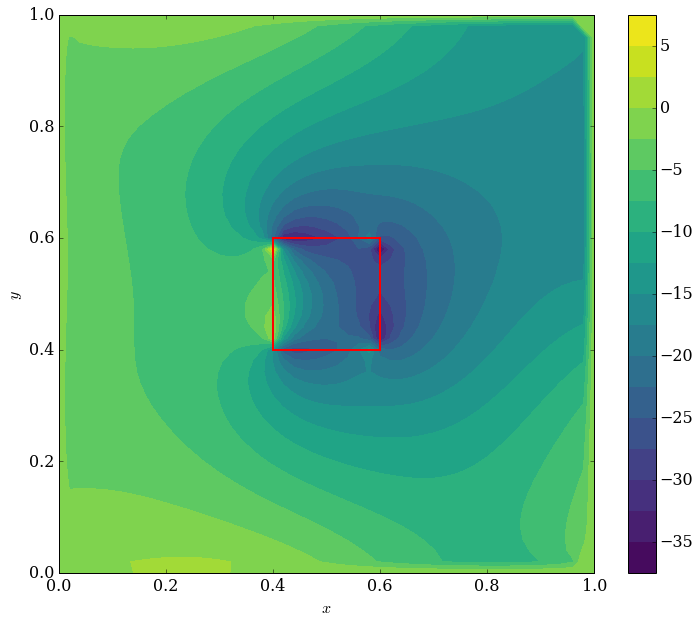

In [108]:
P31,iterations=laplace2d1(lapx3,lapy3, l1_target,nx,ny,dx,dy)
print("iterations=",iterations)
pyplot.figure(figsize=(12,10))
pyplot.plot(j,m, color='r', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='r', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='r', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='r', linestyle='-', linewidth=2)
pyplot.contourf(x,y,P31,20,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

##### This pressure field is clearly asymmetric. However, the problem is perfectly symmetric, and the flow speed is also symmetric (see above).

This paradox arises from the choice of a first order approximation for the pressure's Neumann BCs. Indeed, this approximation is asymmetric. Thus, a second order approximation should be more appropriate. 


## Pressure field using 2nd-order Neumann BCs

The 2nd-order approximation (the central-difference approximation) is:

\begin{equation}
\frac{p_{i+1,j} - p_{i-1,j}}{2 dx} = \Delta u_{i,j}
\end{equation}

and

\begin{equation}
\frac{p_{i,j+1} - p_{i,j-1}}{2 dy} = \Delta v_{i,j}
\end{equation}

The expression for the pressure on the left edge of the cavity is given by the finite-difference Jacobi equation with $i=0$:

\begin{equation}
p^{k+1}_{0,j} = \frac{1}{4} \left(p^{k}_{0,j-1} + p^k_{0,j+1} + p^{k}_{-1,j} + p^k_{1,j} \right)
\end{equation}

The problem is that the point $p_{-1,j}$ is out of the domain. However, according to the 2nd-order approximation,

\begin{equation}
p_{i-1,j} = -2dx\Delta u_{i,j}+p_{i+1,j}
\end{equation}

We've completed the 2nd-order Neumann condition:

\begin{equation}
p_{0,j} = \frac{1}{4} \left(-2dx\Delta u_{0,j}+p_{0,j-1} + p_{0,j+1} + 2p_{1,j} \right)
\end{equation}

From a similar argument, we find the conditions on the other edges of the cavity and on the central square.

In [109]:
def laplace2d2(lapx,lapy, l1_target,nx,ny,dx,dy):
    '''Iteratively solves the Laplace equation using the Jacobi method
    
    Parameters:
    ----------
    P: 2D array of float
        Initial Pressure distribution
    lapx: 2D array of float
        x component of the speed laplacian
    lapy:2D array of float
        y component of the speed laplacian
    l1_target: float
        target for the difference between consecutive solutions
    nx: float
        array size x axis
    ny:float
        array size y axis
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
        
    Returns:
    -------
    P: 2D array of float
        Pressure distribution after relaxation
    ''' 
    
    l2norm = 1
    P=numpy.zeros((nx,ny))

    pn = numpy.empty_like(p)
    iterations = 0
    lnorm=1
    
    while lnorm > l1_target:
        Pn = P.copy()
        
        P[2:-2,2:-2] = 0.25 * (Pn[2:-2,3:-1] + Pn[2:-2, 1:-3] \
                              + Pn[3:-1, 2:-2] + Pn[1:-3, 2:-2])
        
        
        ##Neumann B.C. along x = 0
        P[2:-2,1]= .25*(-2*dx*lapx[2:-2,1]+Pn[1:-3,1]+Pn[3:-1,1]+2*Pn[2:-2,2])
        
        ##Neumann B.C. along x = L
        P[2:-2,-2]= .25*(2*dx*lapx[2:-2,-2]+Pn[1:-3,-2]+Pn[3:-1,-2]+2*Pn[2:-2,-3])
        
        ##Neumann B.C. along y = 0
        
        P[1,2:-2]= .25*(-2*dx*lapy[1,2:-2]+2*Pn[2,2:-2]+Pn[1,1:-3]+Pn[1,3:-1])
        
        ##Neumann B.C. along y = L
        
        P[-2,2:-2]= .25*(2*dx*lapy[-2,2:-2]+2*Pn[-3,2:-2]+Pn[-2,1:-3]+Pn[-2,3:-1])
        
        ##Neumann B.C. along the left side of the cube
        P[yi-r:yi+r+1,xi-r]= .25*(2*dx*lapx[yi-r:yi+r+1,xi-r]+Pn[yi-r-1:yi+r,xi-r]\
                                  +Pn[yi-r+1:yi+r+2,xi-r]+2*Pn[yi-r:yi+r+1,xi-r-1])
        
        
        ##Neumann B.C. along the right side of the cube
        P[yi-r:yi+r+1,xi+r]=.25*(-2*dx*lapx[yi-r:yi+r+1,xi+r]+Pn[yi-r-1:yi+r,xi+r]\
                                 +Pn[yi-r+1:yi+r+2,xi+r]+2*Pn[yi-r:yi+r+1,xi+r+1])
        
        ##Neumann B.C. along the up side of the cube
        P[yi+r,xi-r:xi+r+1]=.25*(-2*dx*lapy[yi+r,xi-r:xi+r+1]+2*Pn[yi+r+1,xi-r:xi+r+1]\
                                 +Pn[yi+r,xi-r-1:xi+r]+Pn[yi+r,xi-r+1:xi+r+2])
        
        ##Neumann B.C. along the down side of the cube
        
        P[yi-r,xi-r:xi+r+1]= .25*(2*dx*lapy[yi-r,xi-r:xi+r+1]+2*Pn[yi-r-1,xi-r:xi+r+1]\
                                  +Pn[yi-r,xi-r-1:xi+r]+Pn[yi-r,xi-r+1:xi+r+2])
        
        lnorm = L1norm(P, Pn)
        iterations+=1
        
    return P,iterations

## symmetric laplace equation solver

The last bit of our code that is not symmetric is a little bit tricky to catch. First, it is good to understand that a lot of different codes, with different ordrers approximations for example, are going to converge towards the same physical solution. Even though each code is right regarding the fact that it will get closer to the real solution after each iteration, different code might have different properties all the way to that solution. For example, a code might not be symmetric but, give a result that converges towards a symmetric solution. Other codes might be symmetric at each iteration, and converge towards the same solution. Since symmetry is really what we are after, we need to make sure our code is thoroughly symmetric. We will see that the actual asymmetry lies in the disposition of boundaries contition on the vorticity $\omega$ in term of the potential flow $\psi$ used for the Laplace solver.

They are, for the moment, implemented as follow:

On the cavity:

Along the top surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j-1} - 7\psi_{i, j} - \psi_{i, j-2}) - \frac{3u}{\Delta y}
\end{equation}

along the bottom surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j+1}- 7\psi_{i, j} - \psi_{i, j+2})+ \frac{3u}{\Delta y}
\end{equation}

along the left surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta x^2} (8\psi_{i+1, j}- 7\psi_{i, j} - \psi_{i+2, j})
\end{equation}

and along the right surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta x^2} (8\psi_{i-1, j}- 7\psi_{i, j} - \psi_{i-2, j})
\end{equation}

On the central square:

along the bottom surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j+1}- 7\psi_{i, j} - \psi_{i, j+2})
\end{equation}


along the left surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta x^2} (8\psi_{i+1, j}- 7\psi_{i, j} - \psi_{i+2, j})
\end{equation}

Along the top surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j-1} - 7\psi_{i, j} - \psi_{i, j-2})
\end{equation}

and along the right surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta x^2} (8\psi_{i-1, j}- 7\psi_{i, j} - \psi_{i-2, j})
\end{equation}

The disposition, or order, in which they are implemented does not seem to matter much. But it is actually primordial regarding symmetry. We will try to illustrate why.

First, we need to see that those conditions are defined using the values of points inside the domain. The way those points are used can thus affect the symmetry of the code. Also, the point at the intersection of each surface on which the value of $\omega$ is computed is redefined for each condition. 

Let's take the case of the central square. For the top surface condition, the computation of the value of $\omega_{i,j}$ requires the values of $\psi_{i, j+1}$, $ \psi_{i, j}$, and $ \psi_{i, j+2}$. That means we need the value of $psi$ on points along the y-axis. If arrows represent the axis where values of $\psi$ are used to compute $\omega$, the pattern used can be illustrated as follows:

<img src="./Figures/Fig_sym1.jpg" width=300px length=300px>
#### Figure 1.  BCs on the central square's top surface

Now, keeping in mind that the condition on the corners are redefined for each condition, the complete set of boundary conditions on the square can be illustrated as follows:


<img src="./Figures/Fig_sym2.jpg" width=300px length=300px>
#### Figure 1.  BCs on the central square

That is where the asymmetry of our code arose. Now, if we re-order the BCs as follows:

On the central square:

Along the top surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j-1} - 7\psi_{i, j} - \psi_{i, j-2}) - \frac{3u}{\Delta y}
\end{equation}

along the bottom surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j+1}- 7\psi_{i, j} - \psi_{i, j+2})+ \frac{3u}{\Delta y}
\end{equation}

along the left surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta x^2} (8\psi_{i+1, j}- 7\psi_{i, j} - \psi_{i+2, j})
\end{equation}

and along the right surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta x^2} (8\psi_{i-1, j}- 7\psi_{i, j} - \psi_{i-2, j})
\end{equation}

The new pattern is illustrated as follows: 

<img src="./Figures/Fig_sym3.jpg" width=300px length=300px>
#### Figure 1. New BCs on the central square

Now, this is symmetrical! 
We can now implement those new conditions.


In [110]:
def BCs_obstacle3(w,psi,y,xi,yi,r,h,u):
    '''BCs for a square obstacle in the middle of the grid and uniform speed u at the edge of the cavity
    
    Parameters:
    ----------
    w : 2D array of floats
        w on the Boundaries
    psi: 2D array of floats
        psi on the Boundaries
    xi: float
        middle of the x axis
    yi: float
        middle of the y axis
    r: float
        1/2 side of the cube
    h: float
        height of the cavity
    u: float
        speed of the flow on the on the edge of the cavity
    
    Returns:
    -------
    psi: 2D array of float
        Distribution after BCs
    w: 2D array of float
        Distribution after BCs
    ''' 

    #BCs cavity
        
    #top
    w[-1,:]= (-1/dx**2)*(6*dy*u-7*psi[-1,:]+8*psi[-2,:]-psi[-3,:])
    #bottom
    w[0,:]= (-1/dx**2)*(-6*dy*u-7*psi[0,:]+8*psi[1,:]-psi[2,:])
    #left
    w[:,0]= (-1/dx**2)*(-7*psi[:,0]+8*psi[:,1]-psi[:,2])
    #right
    w[:,-1]= (-1/dx**2)*(-7*psi[:,-1]+8*psi[:,-2]-psi[:,-3])
    
    #BCs square
    #top
    w[yi+r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi+r+1,xi-r:xi+r+1]-7*u*(h/2)-psi[yi+r+2,xi-r:xi+r+1])
    #bottom
    w[yi-r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi-r-1,xi-r:xi+r+1]-7*u*(h/2)-psi[yi-r-2,xi-r:xi+r+1])
    #left
    w[yi-r:yi+r+1,xi-r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi-r-1]-7*u*(h/2)-psi[yi-r:yi+r+1,xi-r-2])
    #right
    w[yi-r:yi+r+1,xi+r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi+r+1]-7*u*(h/2)-psi[yi-r:yi+r+1,xi+r+2])
        
    return psi,w

w3,psi3,iteration = stokes_system(r,xi,yi,h,nx,ny,w,psi,l1_target,dx,dy,u,3)
ux3, vy3=speed(psi3,nx,ny,dx,dy)
lapx3,lapy3=lap(ux3,vy3,nx,ny,dx,dy)

### We finally obtain the following result for the pressure field

iterations= 12989


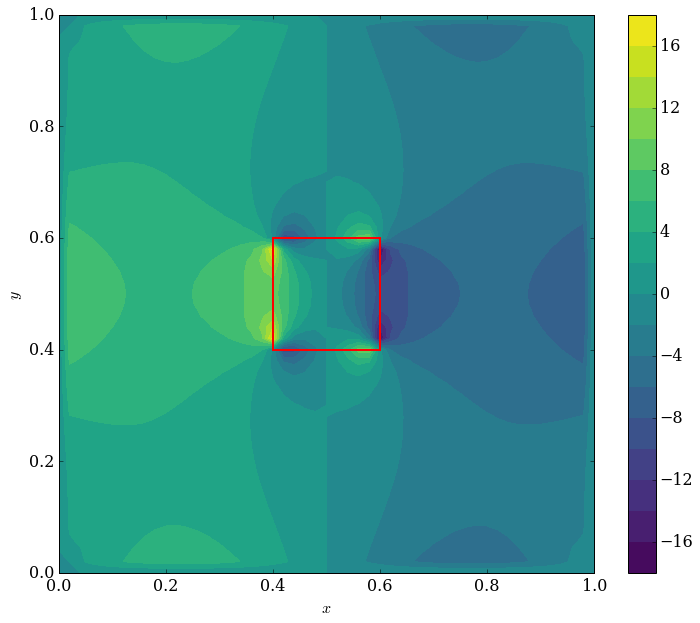

In [111]:
P32,iterations=laplace2d2(lapx3,lapy3, l1_target,nx,ny,dx,dy)
print("iterations=",iterations)
pyplot.figure(figsize=(12,10))
pyplot.plot(j,m, color='r', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='r', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='r', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='r', linestyle='-', linewidth=2)
pyplot.contourf(x,y,P32,20,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

This result looks more symmetric than the first field computed.  Let's code a symmetry check to see if it holds.

In [112]:
def sym(f,yi,r):
    '''symmetry check
    
    Parameters:
    ----------
    
    f: 2D array of float
        field to check
    yi: float 
    position of the center of the central square 
    r: float
        half the lentgth of the central square
        
    Returns:
    -------
    sym: positive float
        sum of the values of the field on two opposite sides of the domain
        (should be very small for a symmetric function)
    '''
    
    sym = abs(numpy.sum(abs(f[yi+r+7,:])-abs(f[yi-r-7,:])))
    return sym

In [113]:
symv=sym(vy3,yi,r)
print("sym speed v=",symv)
symv=sym(ux3,yi,r)
print("sym speed u=",symv)
print()
symlapv=sym(lapy3,yi,r)
print("sym laplacian speed v=",symlapv)
symlapu=sym(lapx3,yi,r)
print("sym laplacian speed u=",symlapu)
print()
symP1=sym(P31,yi,r)
print("sym Pressure 1(first order)=",symP1)
symP2=sym(P32,yi,r)
print("sym Pressure 2(second order)=",symP2)

sym speed v= 9.93403553862e-09
sym speed u= 5.65680258191e-09

sym laplacian speed v= 1.97259741075e-06
sym laplacian speed u= 1.96334168656e-06

sym Pressure 1(first order)= 181.084925509
sym Pressure 2(second order)= 6.92059183663e-08


This test shows that the second order approximation method and the new BCs give a result symmetric up to the computer's precision.

## A More General Approach Than The Choice of Constant

On the original paper, a solution for the potential flow $\psi$ was found when choosing $\psi$ to be zero on the square. The BCs with that choice of constant are implemented below.

In [114]:
def BCs_obstacle2(w,psi,y,xi,yi,r,h,u):
    '''BCs for a square obstacle in the middle of the grid and uniform speed u at the edge of the cavity
    
    Parameters:
    ----------
    w : 2D array of floats
        w on the Boundaries
    psi: 2D array of floats
        psi on the Boundaries
    xi: float
        middle of the x axis
    yi: float
        middle of the y axis
    r: float
        1/2 side of the cube
    h: float
        height of the cavity
    u: float
        speed of the flow on the on the edge of the cavity
    
    Returns:
    -------
    psi: 2D array of float
        Distribution after BCs
    w: 2D array of float
        Distribution after BCs
    ''' 

    #BCs cavity
        
    w[-1,:]= (-1/dx**2)*(6*dy*u-7*psi[-1,:]+8*psi[-2,:]-psi[-3,:])
    w[0,:]= (-1/dx**2)*(-6*dy*u-7*psi[0,:]+8*psi[1,:]-psi[2,:])
    w[:,0]= (-1/dx**2)*(-7*psi[:,0]+8*psi[:,1]-psi[:,2])
    w[:,-1]= (-1/dx**2)*(-7*psi[:,-1]+8*psi[:,-2]-psi[:,-3])
    
    #BCs square
    w[yi-r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi-r-1,xi-r:xi+r+1]-psi[yi-r-2,xi-r:xi+r+1])
    w[yi-r:yi+r+1,xi-r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi-r-1]-psi[yi-r:yi+r+1,xi-r-2])
    w[yi+r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi+r+1,xi-r:xi+r+1]-psi[yi+r+2,xi-r:xi+r+1])
    w[yi-r:yi+r+1,xi+r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi+r+1]-psi[yi-r:yi+r+1,xi+r+2])
        
    return psi,w

The potential flow $\psi$ was obtained as fallows:

number of iterations = 2975


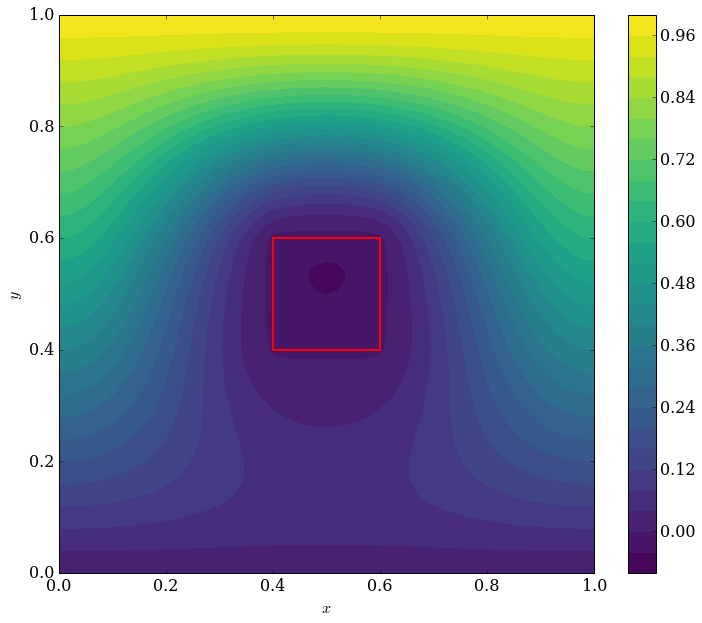

In [115]:
#we choose the second BCs function
boundary=2

#compute psi
w2,psi2,iteration = stokes_system(r,xi,yi,h,nx,ny,w,psi,l1_target,dx,dy,u,boundary)
print("number of iterations =",iteration)


pyplot.figure(figsize=(12,10))

#plot the central square
pyplot.plot(j,m, color='r', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='r', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='r', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='r', linestyle='-', linewidth=2)

#contour plot of psi
pyplot.contourf(x,y,psi2,26,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

This non-physical result is due to a wrong choice of constant for the value of the potential flow $\psi$ on the square.

The right choice of constant we made was based on the symmetry of this problem. If we chose not to put the square in the center of the cavity, the result of our code would not be the physical result. There is nonetheless a general condition on $\omega$ that fixes its value on the boundary. Let's find out what this condition is.

First, we look at the result of the curl of the curl operator applied on the velocity $\vec{u}$

Because the flow is considered incompressible , we have

\begin{equation}
\vec{\nabla} \cdot \vec{u}=0
\end{equation}


From the equation 

\begin{equation}
\vec{\nabla} p = \nabla^2 \vec{u}
\end{equation}

we see that 

\begin{equation}
\vec{\nabla} \times\vec{\nabla} \times\vec{u} =-\vec{\nabla} p 
\end{equation}

We will now take the integral the on contour $\mathcal{C}$ of the square of both side of this equation

\begin{equation}
\int_{\mathcal{C}} (\vec{\nabla} \times\vec{\omega})\cdot\vec{dl} =-\int_{\mathcal{C}}(\vec{\nabla} p) \cdot \vec{dl}
\end{equation}

Where $\vec{dl}=dx\vec{1_x}+dy\vec{1_y}$ is a small vector element along the curve $\mathcal{C}$ . The right hand side of the equation is of course zero since $p$ is a physical value and is thus single-valued. Since $\vec{\omega}=\omega\vec{1_z}$, we finally have

\begin{equation}
\int_{\mathcal{C}} (\vec{\nabla} {\omega})\cdot\vec{dk} =0
\end{equation}

Where $\vec{dk}=-dy\vec{1_x}+dx\vec{1_y}$. It is in fact a unit vector perpendicular to the contour of the square. This means that only the perpendicular component to the square of $ \vec{\nabla} {\omega}$  will contribute to this integral.

We can now implement this condition to see that it is satisfied with the right choice of constant.

In [116]:
def grad(w,dx,dy,nx,ny):
    '''compute the gradient of a function w
    
    Parameters:
    ----------
    w : 2D array of floats
        w on the Boundaries
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    nx: float
        array size x axis
    ny:float
        array size y axis
    Returns:
    -------
    dw_x: 2D array of float
        x-component of the gradient
    dw_y: 2D array of float
        y-component of the gradient
    '''
    dw_x=numpy.zeros((nx,ny))
    dw_y=numpy.zeros((nx,ny))
    dw_x[1:-1,1:-1]=(w[1:-1,2:]-w[1:-1,:-2])/(2*dx)  #x-component of the gradient
    dw_y[1:-1,1:-1]=(w[2:,1:-1]-w[:-2,1:-1])/(2*dy)  #y-component of the gradient
    return dw_x, dw_y

In [117]:
def cont(fx,fy,dx,dy,yi,xi,r):
    '''compute the value of the integral given above
    
    Parameters:
    ----------
    fx : 2D array of floats
        x-component
    fy : 2D array of floats
        y-component
    xi: float
        middle of the x axis
    yi: float
        middle of the y axis
    r: float
        1/2 side of the cube
    Returns:
    -------
    cont: float
        value of the integral

    ''' 
    
    fu=numpy.zeros((2*r+1))  #value of f on the up edge of the square
    fd=numpy.zeros((2*r+1))  #down
    fr=numpy.zeros((2*r+1))  #right
    fl=numpy.zeros((2*r+1))  #left
    fu[:]=fy[yi+r,xi-r:xi+r+1]
    fd[:]=fy[yi-r,xi-r:xi+r+1]
    fr[:]=fx[yi-r:yi+r+1,xi+r]
    fl[:]=fx[yi-r:yi+r+1,xi-r]
    cont=numpy.sum(dy*(fu-fd))+numpy.sum(dx*(fr-fl)) #integral contribution
    return cont

In [118]:
#compute the integral with w3, the potential with the right choice of constant
dw_x3, dw_y3 = grad(w3,dx,dy,nx,ny) 
contw3=cont(dw_x3,dw_y3,dx,dy,yi,xi,r)
print("integral with the right choice of constant=",contw3)

integral with the right choice of constant= -6.91173660883e-08


With the second choice of constant, we model a circulation force $\vec{F}(\theta)$ . The equation for the speed becomes

\begin{equation}
\vec{F}(\theta)+\vec{\nabla} p = \nabla^2 \vec{u}
\end{equation}

Which leads to

\begin{equation}
\int_{\mathcal{C}} (\vec{\nabla} {\omega})\cdot\vec{dk} \ne 0
\end{equation}

In [119]:
#compute the integral with w2, the potential with the right choice of constant
dw_x2, dw_y2 = grad(w2,dx,dy,nx,ny) 
contw2=cont(dw_x2,dw_y2,dx,dy,yi,xi,r)
print("integral with the wrong choice of constant=",contw2)

integral with the wrong choice of constant= -113.340761071


It is clear that the choice of constant corresponding to the physical solution gives a result really close to zero while the other solution does not.

## Conclusion

Even though the code used on the first paper gave a result that converges towards the physical solution, it did not make the use of symmetric conditions. That means that our symmetry test would give good results only for a system with extremely high resolution, meaning a lot of computing time. Now with a thoroughly symmetric code, for any resolution, the system will be symmetric.

Also now that the integral test for the physical result is working, we could compute the value of this integral, at each iteration of the stokes system solver. We could then choose the solution of the flow for which the value of this integral is minimal. It would allow us to solve this problem without the help of symmetry.
This could also be done for more than one square and eventually for any shape build of small squares! But, this is out of the scope of this report.

##### Source

(1) We used the following lectures https://github.com/numerical-mooc/numerical-mooc available under Creative Commons Attribution license CC-BY 4.0, (c)2014 L.A. Barba, C. Cooper, G.F. Forsyth, A. Krishnan.

In [120]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())